In [1]:
import argparse
import multiprocessing
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Use if using compilation-dependent reproducibility

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import torch

from piano import Composer, time_code

try:
    import rapids_singlecell as rsc
    use_rapids = True
    print('Using rapids singlecell to speed up postprocessing', flush=True)
except:
    print('Warning: Unable to use rapids singlecell in this environment', flush=True)
    use_rapids = False
np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(precision=3, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using rapids singlecell to speed up postprocessing


In [2]:
# Run parameters
run_name = 'piano_v0.0.3'
outdir = f'/results/piano_whole_brain_integration/piano/{run_name}'
os.makedirs(f'{outdir}/integration_results', exist_ok=True)
os.makedirs(f'{outdir}/figures', exist_ok=True)

print(f'Number of CPU cores: {multiprocessing.cpu_count()}', flush=True)
print(f'Number of GPUs: {torch.cuda.device_count()}', flush=True)
print(f'CUDA GPUs available: {torch.cuda.is_available()}', flush=True)

Number of CPU cores: 16
Number of GPUs: 1
CUDA GPUs available: True


In [3]:
with time_code('Load Anndata'):
    adata = sc.read_h5ad("/data/Whole_brain_human_mouse_datasets__07_13_2025/adata_orthologs_subset_100_per_cluster_without_Macosko.h5ad")
    print(f"Training on: {adata}")

[Load Anndata] start @: 10_04_2025_19:32:19
Training on: AnnData object with n_obs × n_vars = 739322 × 15116
    obs: 'AIT21__library_prep', 'AIT21__gene.counts.0', 'AIT21__doublet_score', 'AIT21__roi', 'AIT21__umi.counts', 'AIT21__method', 'AIT21__sex', 'AIT21__external_donor_name', 'AIT21__age', 'AIT21__medical_conditions', 'AIT21__cl', 'AIT21__region_label', 'Atlas_label', 'Species_label', 'Platform_label', 'Donor_label', 'Region_label', 'Siletti__batch', 'Siletti__donor_name', 'Siletti__library_prep', 'Siletti__method', 'Siletti__roi', 'Siletti__sex', 'Siletti__ROIGroupFine', 'Siletti__development_stage', 'Siletti__self_reported_ethnicity', 'Siletti__supercluster_term', 'Siletti__cluster_id', 'Siletti__subcluster_id'
[Load Anndata] runtime: 0 min 47 sec


In [4]:
with time_code('Initialize Pianist'):
    pianist = Composer(
        adata,
        categorical_covariate_keys = ['Species_label', 'Platform_label'],  # Discrete batch effects
        continuous_covariate_keys = [],                                    # Continuous sources of variation
        n_top_genes=4096,                                                  # Number of highly variable genes to use
        hvg_batch_key='Species_label',                                     # Used for SeuratV3 highly variable gene (HVG) selection
        max_epochs=200,      # Max number of training epochs
        memory_mode='GPU',   # Use GPU
        compile_model=True,  # Recommended if hardware supports torch.compile
        num_workers=0,       # Set to 0 if using GPU, otherwise ~11 workers
        deterministic=True,  # Requires CUBLAS_WORKSPACE_CONFIG=:4096:8 if compiling
        run_name=run_name,
        outdir=outdir,
    )

[Initialize Pianist] start @: 10_04_2025_19:33:06
[Initialize Pianist] runtime: 0 min 0 sec


In [5]:
with time_code('Run pipeline'):
    pianist.run_pipeline()

[Run pipeline] start @: 10_04_2025_19:33:06
Preparing data with parameters: ('seurat_v3', 4096, 'Species_label')
Preparing training data
Preparing model with input size: 4096, distribution: nb, padding size: None, categorical_covariate_keys: [('Species_label', np.int64(2)), ('Platform_label', np.int64(4))], continuous_covariate_keys: []
Training model with up to 200 epochs and random seed: 0
Training started for piano_v0.0.3 using device=cuda and memory_mode=GPU
Model compiling for up to 10x faster training


Epoch 0/200: 100%|██████████| 5775/5775 [00:11<00:00, 503.84batch/s]


Epoch ELBO: 3325.444, NLL: 3329.253, KLD: 103.091, KLD weight: 0.002500
Epoch improvement of inf >= min_delta of 1.000


Epoch 1/200: 100%|██████████| 5775/5775 [00:06<00:00, 847.85batch/s]


Epoch ELBO: 3057.196, NLL: 3068.138, KLD: 137.412, KLD weight: 0.005000
Epoch improvement of 268.248 >= min_delta of 1.000


Epoch 2/200: 100%|██████████| 5775/5775 [00:07<00:00, 810.88batch/s]


Epoch ELBO: 3021.707, NLL: 3039.816, KLD: 124.731, KLD weight: 0.007500
Epoch improvement of 35.489 >= min_delta of 1.000


Epoch 3/200: 100%|██████████| 5775/5775 [00:06<00:00, 841.53batch/s]


Epoch ELBO: 3001.666, NLL: 3026.890, KLD: 117.376, KLD weight: 0.010000
Epoch improvement of 20.041 >= min_delta of 1.000


Epoch 4/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.66batch/s]


Epoch ELBO: 2986.931, NLL: 3019.270, KLD: 112.063, KLD weight: 0.012500
Epoch improvement of 14.735 >= min_delta of 1.000


Epoch 5/200: 100%|██████████| 5775/5775 [00:06<00:00, 835.75batch/s]


Epoch ELBO: 2974.672, NLL: 3014.086, KLD: 107.935, KLD weight: 0.015000
Epoch improvement of 12.259 >= min_delta of 1.000


Epoch 6/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.83batch/s]


Epoch ELBO: 2963.895, NLL: 3010.355, KLD: 104.363, KLD weight: 0.017500
Epoch improvement of 10.778 >= min_delta of 1.000


Epoch 7/200: 100%|██████████| 5775/5775 [00:06<00:00, 844.59batch/s]


Epoch ELBO: 2954.103, NLL: 3007.592, KLD: 101.212, KLD weight: 0.020000
Epoch improvement of 9.792 >= min_delta of 1.000


Epoch 8/200: 100%|██████████| 5775/5775 [00:06<00:00, 846.23batch/s]


Epoch ELBO: 2944.772, NLL: 3005.256, KLD: 98.645, KLD weight: 0.022500
Epoch improvement of 9.331 >= min_delta of 1.000


Epoch 9/200: 100%|██████████| 5775/5775 [00:06<00:00, 835.01batch/s]


Epoch ELBO: 2936.015, NLL: 3003.459, KLD: 96.327, KLD weight: 0.025000
Epoch improvement of 8.757 >= min_delta of 1.000


Epoch 10/200: 100%|██████████| 5775/5775 [00:07<00:00, 813.47batch/s]


Epoch ELBO: 2927.390, NLL: 3001.761, KLD: 94.280, KLD weight: 0.027500
Epoch improvement of 8.625 >= min_delta of 1.000


Epoch 11/200: 100%|██████████| 5775/5775 [00:07<00:00, 816.21batch/s]


Epoch ELBO: 2919.197, NLL: 3000.460, KLD: 92.441, KLD weight: 0.030000
Epoch improvement of 8.194 >= min_delta of 1.000


Epoch 12/200: 100%|██████████| 5775/5775 [00:07<00:00, 791.56batch/s]


Epoch ELBO: 2910.973, NLL: 2999.104, KLD: 90.771, KLD weight: 0.032500
Epoch improvement of 8.223 >= min_delta of 1.000


Epoch 13/200: 100%|██████████| 5775/5775 [00:06<00:00, 844.56batch/s]


Epoch ELBO: 2903.095, NLL: 2998.055, KLD: 89.315, KLD weight: 0.035000
Epoch improvement of 7.878 >= min_delta of 1.000


Epoch 14/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.11batch/s]


Epoch ELBO: 2895.518, NLL: 2997.292, KLD: 87.891, KLD weight: 0.037500
Epoch improvement of 7.577 >= min_delta of 1.000


Epoch 15/200: 100%|██████████| 5775/5775 [00:06<00:00, 836.76batch/s]


Epoch ELBO: 2887.837, NLL: 2996.384, KLD: 86.655, KLD weight: 0.040000
Epoch improvement of 7.682 >= min_delta of 1.000


Epoch 16/200: 100%|██████████| 5775/5775 [00:06<00:00, 836.91batch/s]


Epoch ELBO: 2880.482, NLL: 2995.770, KLD: 85.573, KLD weight: 0.042500
Epoch improvement of 7.355 >= min_delta of 1.000


Epoch 17/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.51batch/s]


Epoch ELBO: 2873.017, NLL: 2995.024, KLD: 84.324, KLD weight: 0.045000
Epoch improvement of 7.465 >= min_delta of 1.000


Epoch 18/200: 100%|██████████| 5775/5775 [00:07<00:00, 806.91batch/s]


Epoch ELBO: 2865.846, NLL: 2994.530, KLD: 83.428, KLD weight: 0.047500
Epoch improvement of 7.170 >= min_delta of 1.000


Epoch 19/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.25batch/s]


Epoch ELBO: 2858.606, NLL: 2993.948, KLD: 82.392, KLD weight: 0.050000
Epoch improvement of 7.240 >= min_delta of 1.000


Epoch 20/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.60batch/s]


Epoch ELBO: 2851.391, NLL: 2993.348, KLD: 81.474, KLD weight: 0.052500
Epoch improvement of 7.216 >= min_delta of 1.000


Epoch 21/200: 100%|██████████| 5775/5775 [00:06<00:00, 829.00batch/s]


Epoch ELBO: 2844.338, NLL: 2992.889, KLD: 80.513, KLD weight: 0.055000
Epoch improvement of 7.053 >= min_delta of 1.000


Epoch 22/200: 100%|██████████| 5775/5775 [00:06<00:00, 838.32batch/s]


Epoch ELBO: 2837.325, NLL: 2992.437, KLD: 79.677, KLD weight: 0.057500
Epoch improvement of 7.013 >= min_delta of 1.000


Epoch 23/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.24batch/s]


Epoch ELBO: 2830.385, NLL: 2992.032, KLD: 78.891, KLD weight: 0.060000
Epoch improvement of 6.940 >= min_delta of 1.000


Epoch 24/200: 100%|██████████| 5775/5775 [00:06<00:00, 842.16batch/s]


Epoch ELBO: 2823.456, NLL: 2991.606, KLD: 78.168, KLD weight: 0.062500
Epoch improvement of 6.928 >= min_delta of 1.000


Epoch 25/200: 100%|██████████| 5775/5775 [00:07<00:00, 814.74batch/s]


Epoch ELBO: 2816.646, NLL: 2991.261, KLD: 77.457, KLD weight: 0.065000
Epoch improvement of 6.810 >= min_delta of 1.000


Epoch 26/200: 100%|██████████| 5775/5775 [00:07<00:00, 810.10batch/s]


Epoch ELBO: 2809.862, NLL: 2990.937, KLD: 76.671, KLD weight: 0.067500
Epoch improvement of 6.784 >= min_delta of 1.000


Epoch 27/200: 100%|██████████| 5775/5775 [00:07<00:00, 819.68batch/s]


Epoch ELBO: 2803.123, NLL: 2990.621, KLD: 75.955, KLD weight: 0.070000
Epoch improvement of 6.739 >= min_delta of 1.000


Epoch 28/200: 100%|██████████| 5775/5775 [00:07<00:00, 781.69batch/s]


Epoch ELBO: 2796.391, NLL: 2990.268, KLD: 75.369, KLD weight: 0.072500
Epoch improvement of 6.732 >= min_delta of 1.000


Epoch 29/200: 100%|██████████| 5775/5775 [00:06<00:00, 841.80batch/s]


Epoch ELBO: 2789.694, NLL: 2989.913, KLD: 74.765, KLD weight: 0.075000
Epoch improvement of 6.697 >= min_delta of 1.000


Epoch 30/200: 100%|██████████| 5775/5775 [00:07<00:00, 808.04batch/s]


Epoch ELBO: 2783.207, NLL: 2989.775, KLD: 74.086, KLD weight: 0.077500
Epoch improvement of 6.487 >= min_delta of 1.000


Epoch 31/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.13batch/s]


Epoch ELBO: 2776.634, NLL: 2989.510, KLD: 73.443, KLD weight: 0.080000
Epoch improvement of 6.573 >= min_delta of 1.000


Epoch 32/200: 100%|██████████| 5775/5775 [00:07<00:00, 798.79batch/s]


Epoch ELBO: 2770.065, NLL: 2989.215, KLD: 72.775, KLD weight: 0.082500
Epoch improvement of 6.569 >= min_delta of 1.000


Epoch 33/200: 100%|██████████| 5775/5775 [00:07<00:00, 809.17batch/s]


Epoch ELBO: 2763.564, NLL: 2988.972, KLD: 72.145, KLD weight: 0.085000
Epoch improvement of 6.501 >= min_delta of 1.000


Epoch 34/200: 100%|██████████| 5775/5775 [00:06<00:00, 840.75batch/s]


Epoch ELBO: 2757.179, NLL: 2988.814, KLD: 71.609, KLD weight: 0.087500
Epoch improvement of 6.385 >= min_delta of 1.000


Epoch 35/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.37batch/s]


Epoch ELBO: 2750.787, NLL: 2988.607, KLD: 71.056, KLD weight: 0.090000
Epoch improvement of 6.392 >= min_delta of 1.000


Epoch 36/200: 100%|██████████| 5775/5775 [00:06<00:00, 841.63batch/s]


Epoch ELBO: 2744.333, NLL: 2988.320, KLD: 70.446, KLD weight: 0.092500
Epoch improvement of 6.454 >= min_delta of 1.000


Epoch 37/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.45batch/s]


Epoch ELBO: 2737.939, NLL: 2988.067, KLD: 69.932, KLD weight: 0.095000
Epoch improvement of 6.393 >= min_delta of 1.000


Epoch 38/200: 100%|██████████| 5775/5775 [00:06<00:00, 838.95batch/s]


Epoch ELBO: 2731.659, NLL: 2987.906, KLD: 69.372, KLD weight: 0.097500
Epoch improvement of 6.280 >= min_delta of 1.000


Epoch 39/200: 100%|██████████| 5775/5775 [00:06<00:00, 836.36batch/s]


Epoch ELBO: 2725.470, NLL: 2987.807, KLD: 68.828, KLD weight: 0.100000
Epoch improvement of 6.190 >= min_delta of 1.000


Epoch 40/200: 100%|██████████| 5775/5775 [00:06<00:00, 837.67batch/s]


Epoch ELBO: 2719.242, NLL: 2987.637, KLD: 68.374, KLD weight: 0.102500
Epoch improvement of 6.227 >= min_delta of 1.000


Epoch 41/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.97batch/s]


Epoch ELBO: 2713.005, NLL: 2987.449, KLD: 67.750, KLD weight: 0.105000
Epoch improvement of 6.238 >= min_delta of 1.000


Epoch 42/200: 100%|██████████| 5775/5775 [00:07<00:00, 808.55batch/s]


Epoch ELBO: 2706.877, NLL: 2987.340, KLD: 67.228, KLD weight: 0.107500
Epoch improvement of 6.128 >= min_delta of 1.000


Epoch 43/200: 100%|██████████| 5775/5775 [00:06<00:00, 830.07batch/s]


Epoch ELBO: 2700.740, NLL: 2987.190, KLD: 66.753, KLD weight: 0.110000
Epoch improvement of 6.137 >= min_delta of 1.000


Epoch 44/200: 100%|██████████| 5775/5775 [00:07<00:00, 815.37batch/s]


Epoch ELBO: 2694.624, NLL: 2987.038, KLD: 66.193, KLD weight: 0.112500
Epoch improvement of 6.116 >= min_delta of 1.000


Epoch 45/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.97batch/s]


Epoch ELBO: 2688.488, NLL: 2986.833, KLD: 65.702, KLD weight: 0.115000
Epoch improvement of 6.136 >= min_delta of 1.000


Epoch 46/200: 100%|██████████| 5775/5775 [00:06<00:00, 837.60batch/s]


Epoch ELBO: 2682.548, NLL: 2986.816, KLD: 65.162, KLD weight: 0.117500
Epoch improvement of 5.941 >= min_delta of 1.000


Epoch 47/200: 100%|██████████| 5775/5775 [00:07<00:00, 819.90batch/s]


Epoch ELBO: 2676.495, NLL: 2986.662, KLD: 64.551, KLD weight: 0.120000
Epoch improvement of 6.053 >= min_delta of 1.000


Epoch 48/200: 100%|██████████| 5775/5775 [00:07<00:00, 773.73batch/s]


Epoch ELBO: 2670.521, NLL: 2986.545, KLD: 64.083, KLD weight: 0.122500
Epoch improvement of 5.974 >= min_delta of 1.000


Epoch 49/200: 100%|██████████| 5775/5775 [00:06<00:00, 830.09batch/s]


Epoch ELBO: 2664.529, NLL: 2986.390, KLD: 63.617, KLD weight: 0.125000
Epoch improvement of 5.992 >= min_delta of 1.000


Epoch 50/200: 100%|██████████| 5775/5775 [00:06<00:00, 833.56batch/s]


Epoch ELBO: 2658.595, NLL: 2986.264, KLD: 63.139, KLD weight: 0.127500
Epoch improvement of 5.934 >= min_delta of 1.000


Epoch 51/200: 100%|██████████| 5775/5775 [00:06<00:00, 829.23batch/s]


Epoch ELBO: 2652.761, NLL: 2986.238, KLD: 62.619, KLD weight: 0.130000
Epoch improvement of 5.834 >= min_delta of 1.000


Epoch 52/200: 100%|██████████| 5775/5775 [00:07<00:00, 814.45batch/s]


Epoch ELBO: 2646.813, NLL: 2986.040, KLD: 62.225, KLD weight: 0.132500
Epoch improvement of 5.948 >= min_delta of 1.000


Epoch 53/200: 100%|██████████| 5775/5775 [00:07<00:00, 822.33batch/s]


Epoch ELBO: 2640.978, NLL: 2985.938, KLD: 61.818, KLD weight: 0.135000
Epoch improvement of 5.835 >= min_delta of 1.000


Epoch 54/200: 100%|██████████| 5775/5775 [00:06<00:00, 845.54batch/s]


Epoch ELBO: 2635.187, NLL: 2985.849, KLD: 61.504, KLD weight: 0.137500
Epoch improvement of 5.791 >= min_delta of 1.000


Epoch 55/200: 100%|██████████| 5775/5775 [00:06<00:00, 834.81batch/s]


Epoch ELBO: 2629.432, NLL: 2985.784, KLD: 61.100, KLD weight: 0.140000
Epoch improvement of 5.755 >= min_delta of 1.000


Epoch 56/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.21batch/s]


Epoch ELBO: 2623.704, NLL: 2985.727, KLD: 60.708, KLD weight: 0.142500
Epoch improvement of 5.729 >= min_delta of 1.000


Epoch 57/200: 100%|██████████| 5775/5775 [00:06<00:00, 845.69batch/s]


Epoch ELBO: 2617.986, NLL: 2985.648, KLD: 60.375, KLD weight: 0.145000
Epoch improvement of 5.718 >= min_delta of 1.000


Epoch 58/200: 100%|██████████| 5775/5775 [00:06<00:00, 849.35batch/s]


Epoch ELBO: 2612.262, NLL: 2985.532, KLD: 59.969, KLD weight: 0.147500
Epoch improvement of 5.724 >= min_delta of 1.000


Epoch 59/200: 100%|██████████| 5775/5775 [00:06<00:00, 852.50batch/s]


Epoch ELBO: 2606.454, NLL: 2985.292, KLD: 59.633, KLD weight: 0.150000
Epoch improvement of 5.808 >= min_delta of 1.000


Epoch 60/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.49batch/s]


Epoch ELBO: 2600.988, NLL: 2985.411, KLD: 59.292, KLD weight: 0.152500
Epoch improvement of 5.466 >= min_delta of 1.000


Epoch 61/200: 100%|██████████| 5775/5775 [00:06<00:00, 834.85batch/s]


Epoch ELBO: 2595.137, NLL: 2985.049, KLD: 59.045, KLD weight: 0.155000
Epoch improvement of 5.851 >= min_delta of 1.000


Epoch 62/200: 100%|██████████| 5775/5775 [00:06<00:00, 829.23batch/s]


Epoch ELBO: 2589.584, NLL: 2985.040, KLD: 58.661, KLD weight: 0.157500
Epoch improvement of 5.553 >= min_delta of 1.000


Epoch 63/200: 100%|██████████| 5775/5775 [00:06<00:00, 841.10batch/s]


Epoch ELBO: 2584.128, NLL: 2985.093, KLD: 58.358, KLD weight: 0.160000
Epoch improvement of 5.456 >= min_delta of 1.000


Epoch 64/200: 100%|██████████| 5775/5775 [00:07<00:00, 813.46batch/s]


Epoch ELBO: 2578.613, NLL: 2985.052, KLD: 58.058, KLD weight: 0.162500
Epoch improvement of 5.515 >= min_delta of 1.000


Epoch 65/200: 100%|██████████| 5775/5775 [00:07<00:00, 806.21batch/s]


Epoch ELBO: 2573.011, NLL: 2984.894, KLD: 57.742, KLD weight: 0.165000
Epoch improvement of 5.602 >= min_delta of 1.000


Epoch 66/200: 100%|██████████| 5775/5775 [00:07<00:00, 818.32batch/s]


Epoch ELBO: 2567.522, NLL: 2984.828, KLD: 57.436, KLD weight: 0.167500
Epoch improvement of 5.489 >= min_delta of 1.000


Epoch 67/200: 100%|██████████| 5775/5775 [00:06<00:00, 832.40batch/s]


Epoch ELBO: 2561.975, NLL: 2984.668, KLD: 57.149, KLD weight: 0.170000
Epoch improvement of 5.547 >= min_delta of 1.000


Epoch 68/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.22batch/s]


Epoch ELBO: 2556.696, NLL: 2984.783, KLD: 56.857, KLD weight: 0.172500
Epoch improvement of 5.279 >= min_delta of 1.000


Epoch 69/200: 100%|██████████| 5775/5775 [00:06<00:00, 834.06batch/s]


Epoch ELBO: 2551.264, NLL: 2984.719, KLD: 56.561, KLD weight: 0.175000
Epoch improvement of 5.432 >= min_delta of 1.000


Epoch 70/200: 100%|██████████| 5775/5775 [00:06<00:00, 845.55batch/s]


Epoch ELBO: 2545.823, NLL: 2984.603, KLD: 56.287, KLD weight: 0.177500
Epoch improvement of 5.441 >= min_delta of 1.000


Epoch 71/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.96batch/s]


Epoch ELBO: 2540.317, NLL: 2984.395, KLD: 55.975, KLD weight: 0.180000
Epoch improvement of 5.506 >= min_delta of 1.000


Epoch 72/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.53batch/s]


Epoch ELBO: 2535.147, NLL: 2984.543, KLD: 55.726, KLD weight: 0.182500
Epoch improvement of 5.170 >= min_delta of 1.000


Epoch 73/200: 100%|██████████| 5775/5775 [00:07<00:00, 754.91batch/s]


Epoch ELBO: 2529.844, NLL: 2984.512, KLD: 55.448, KLD weight: 0.185000
Epoch improvement of 5.302 >= min_delta of 1.000


Epoch 74/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.43batch/s]


Epoch ELBO: 2524.535, NLL: 2984.458, KLD: 55.165, KLD weight: 0.187500
Epoch improvement of 5.309 >= min_delta of 1.000


Epoch 75/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.12batch/s]


Epoch ELBO: 2519.152, NLL: 2984.277, KLD: 54.870, KLD weight: 0.190000
Epoch improvement of 5.384 >= min_delta of 1.000


Epoch 76/200: 100%|██████████| 5775/5775 [00:06<00:00, 825.30batch/s]


Epoch ELBO: 2514.006, NLL: 2984.358, KLD: 54.630, KLD weight: 0.192500
Epoch improvement of 5.146 >= min_delta of 1.000


Epoch 77/200: 100%|██████████| 5775/5775 [00:07<00:00, 822.99batch/s]


Epoch ELBO: 2508.655, NLL: 2984.171, KLD: 54.372, KLD weight: 0.195000
Epoch improvement of 5.351 >= min_delta of 1.000


Epoch 78/200: 100%|██████████| 5775/5775 [00:06<00:00, 831.32batch/s]


Epoch ELBO: 2503.467, NLL: 2984.151, KLD: 54.108, KLD weight: 0.197500
Epoch improvement of 5.188 >= min_delta of 1.000


Epoch 79/200: 100%|██████████| 5775/5775 [00:06<00:00, 837.70batch/s]


Epoch ELBO: 2498.330, NLL: 2984.170, KLD: 53.860, KLD weight: 0.200000
Epoch improvement of 5.137 >= min_delta of 1.000


Epoch 80/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.77batch/s]


Epoch ELBO: 2493.066, NLL: 2984.004, KLD: 53.608, KLD weight: 0.202500
Epoch improvement of 5.263 >= min_delta of 1.000


Epoch 81/200: 100%|██████████| 5775/5775 [00:07<00:00, 815.86batch/s]


Epoch ELBO: 2487.938, NLL: 2983.984, KLD: 53.361, KLD weight: 0.205000
Epoch improvement of 5.128 >= min_delta of 1.000


Epoch 82/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.91batch/s]


Epoch ELBO: 2482.885, NLL: 2984.045, KLD: 53.028, KLD weight: 0.207500
Epoch improvement of 5.054 >= min_delta of 1.000


Epoch 83/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.64batch/s]


Epoch ELBO: 2477.734, NLL: 2983.940, KLD: 52.818, KLD weight: 0.210000
Epoch improvement of 5.150 >= min_delta of 1.000


Epoch 84/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.14batch/s]


Epoch ELBO: 2472.651, NLL: 2983.896, KLD: 52.578, KLD weight: 0.212500
Epoch improvement of 5.083 >= min_delta of 1.000


Epoch 85/200: 100%|██████████| 5775/5775 [00:07<00:00, 822.31batch/s]


Epoch ELBO: 2467.622, NLL: 2983.897, KLD: 52.277, KLD weight: 0.215000
Epoch improvement of 5.030 >= min_delta of 1.000


Epoch 86/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.78batch/s]


Epoch ELBO: 2462.546, NLL: 2983.800, KLD: 52.081, KLD weight: 0.217500
Epoch improvement of 5.075 >= min_delta of 1.000


Epoch 87/200: 100%|██████████| 5775/5775 [00:06<00:00, 830.37batch/s]


Epoch ELBO: 2457.585, NLL: 2983.837, KLD: 51.865, KLD weight: 0.220000
Epoch improvement of 4.961 >= min_delta of 1.000


Epoch 88/200: 100%|██████████| 5775/5775 [00:06<00:00, 830.64batch/s]


Epoch ELBO: 2452.605, NLL: 2983.821, KLD: 51.614, KLD weight: 0.222500
Epoch improvement of 4.980 >= min_delta of 1.000


Epoch 89/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.31batch/s]


Epoch ELBO: 2447.502, NLL: 2983.638, KLD: 51.365, KLD weight: 0.225000
Epoch improvement of 5.103 >= min_delta of 1.000


Epoch 90/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.07batch/s]


Epoch ELBO: 2442.642, NLL: 2983.712, KLD: 51.148, KLD weight: 0.227500
Epoch improvement of 4.861 >= min_delta of 1.000


Epoch 91/200: 100%|██████████| 5775/5775 [00:06<00:00, 827.88batch/s]


Epoch ELBO: 2437.759, NLL: 2983.757, KLD: 50.898, KLD weight: 0.230000
Epoch improvement of 4.883 >= min_delta of 1.000


Epoch 92/200: 100%|██████████| 5775/5775 [00:06<00:00, 831.74batch/s]


Epoch ELBO: 2432.770, NLL: 2983.626, KLD: 50.715, KLD weight: 0.232500
Epoch improvement of 4.989 >= min_delta of 1.000


Epoch 93/200: 100%|██████████| 5775/5775 [00:07<00:00, 811.39batch/s]


Epoch ELBO: 2427.884, NLL: 2983.599, KLD: 50.517, KLD weight: 0.235000
Epoch improvement of 4.886 >= min_delta of 1.000


Epoch 94/200: 100%|██████████| 5775/5775 [00:07<00:00, 806.79batch/s]


Epoch ELBO: 2423.042, NLL: 2983.597, KLD: 50.323, KLD weight: 0.237500
Epoch improvement of 4.842 >= min_delta of 1.000


Epoch 95/200: 100%|██████████| 5775/5775 [00:07<00:00, 815.54batch/s]


Epoch ELBO: 2418.256, NLL: 2983.643, KLD: 50.140, KLD weight: 0.240000
Epoch improvement of 4.787 >= min_delta of 1.000


Epoch 96/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.47batch/s]


Epoch ELBO: 2413.373, NLL: 2983.558, KLD: 49.933, KLD weight: 0.242500
Epoch improvement of 4.883 >= min_delta of 1.000


Epoch 97/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.71batch/s]


Epoch ELBO: 2408.609, NLL: 2983.572, KLD: 49.780, KLD weight: 0.245000
Epoch improvement of 4.764 >= min_delta of 1.000


Epoch 98/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.49batch/s]


Epoch ELBO: 2403.764, NLL: 2983.483, KLD: 49.558, KLD weight: 0.247500
Epoch improvement of 4.845 >= min_delta of 1.000


Epoch 99/200: 100%|██████████| 5775/5775 [00:06<00:00, 827.80batch/s]


Epoch ELBO: 2398.936, NLL: 2983.399, KLD: 49.344, KLD weight: 0.250000
Epoch improvement of 4.828 >= min_delta of 1.000


Epoch 100/200: 100%|██████████| 5775/5775 [00:07<00:00, 815.39batch/s]


Epoch ELBO: 2394.255, NLL: 2983.452, KLD: 49.177, KLD weight: 0.252500
Epoch improvement of 4.681 >= min_delta of 1.000


Epoch 101/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.70batch/s]


Epoch ELBO: 2389.478, NLL: 2983.372, KLD: 49.007, KLD weight: 0.255000
Epoch improvement of 4.778 >= min_delta of 1.000


Epoch 102/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.44batch/s]


Epoch ELBO: 2384.854, NLL: 2983.462, KLD: 48.811, KLD weight: 0.257500
Epoch improvement of 4.623 >= min_delta of 1.000


Epoch 103/200: 100%|██████████| 5775/5775 [00:07<00:00, 822.22batch/s]


Epoch ELBO: 2380.175, NLL: 2983.454, KLD: 48.657, KLD weight: 0.260000
Epoch improvement of 4.679 >= min_delta of 1.000


Epoch 104/200: 100%|██████████| 5775/5775 [00:07<00:00, 732.68batch/s]


Epoch ELBO: 2375.374, NLL: 2983.273, KLD: 48.473, KLD weight: 0.262500
Epoch improvement of 4.802 >= min_delta of 1.000


Epoch 105/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.29batch/s]


Epoch ELBO: 2370.704, NLL: 2983.224, KLD: 48.344, KLD weight: 0.265000
Epoch improvement of 4.669 >= min_delta of 1.000


Epoch 106/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.66batch/s]


Epoch ELBO: 2366.146, NLL: 2983.312, KLD: 48.162, KLD weight: 0.267500
Epoch improvement of 4.558 >= min_delta of 1.000


Epoch 107/200: 100%|██████████| 5775/5775 [00:06<00:00, 825.99batch/s]


Epoch ELBO: 2361.464, NLL: 2983.204, KLD: 48.015, KLD weight: 0.270000
Epoch improvement of 4.682 >= min_delta of 1.000


Epoch 108/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.75batch/s]


Epoch ELBO: 2356.829, NLL: 2983.138, KLD: 47.844, KLD weight: 0.272500
Epoch improvement of 4.635 >= min_delta of 1.000


Epoch 109/200: 100%|██████████| 5775/5775 [00:06<00:00, 825.88batch/s]


Epoch ELBO: 2352.326, NLL: 2983.214, KLD: 47.708, KLD weight: 0.275000
Epoch improvement of 4.503 >= min_delta of 1.000


Epoch 110/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.55batch/s]


Epoch ELBO: 2347.658, NLL: 2983.068, KLD: 47.524, KLD weight: 0.277500
Epoch improvement of 4.668 >= min_delta of 1.000


Epoch 111/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.66batch/s]


Epoch ELBO: 2343.194, NLL: 2983.150, KLD: 47.384, KLD weight: 0.280000
Epoch improvement of 4.465 >= min_delta of 1.000


Epoch 112/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.68batch/s]


Epoch ELBO: 2338.655, NLL: 2983.108, KLD: 47.243, KLD weight: 0.282500
Epoch improvement of 4.539 >= min_delta of 1.000


Epoch 113/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.70batch/s]


Epoch ELBO: 2334.139, NLL: 2983.092, KLD: 47.089, KLD weight: 0.285000
Epoch improvement of 4.516 >= min_delta of 1.000


Epoch 114/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.97batch/s]


Epoch ELBO: 2329.728, NLL: 2983.160, KLD: 46.974, KLD weight: 0.287500
Epoch improvement of 4.411 >= min_delta of 1.000


Epoch 115/200: 100%|██████████| 5775/5775 [00:07<00:00, 823.84batch/s]


Epoch ELBO: 2325.184, NLL: 2983.069, KLD: 46.788, KLD weight: 0.290000
Epoch improvement of 4.544 >= min_delta of 1.000


Epoch 116/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.16batch/s]


Epoch ELBO: 2320.765, NLL: 2983.111, KLD: 46.626, KLD weight: 0.292500
Epoch improvement of 4.419 >= min_delta of 1.000


Epoch 117/200: 100%|██████████| 5775/5775 [00:06<00:00, 829.61batch/s]


Epoch ELBO: 2316.280, NLL: 2983.041, KLD: 46.462, KLD weight: 0.295000
Epoch improvement of 4.485 >= min_delta of 1.000


Epoch 118/200: 100%|██████████| 5775/5775 [00:06<00:00, 831.62batch/s]


Epoch ELBO: 2311.868, NLL: 2983.035, KLD: 46.327, KLD weight: 0.297500
Epoch improvement of 4.412 >= min_delta of 1.000


Epoch 119/200: 100%|██████████| 5775/5775 [00:06<00:00, 838.71batch/s]


Epoch ELBO: 2307.406, NLL: 2982.958, KLD: 46.161, KLD weight: 0.300000
Epoch improvement of 4.462 >= min_delta of 1.000


Epoch 120/200: 100%|██████████| 5775/5775 [00:06<00:00, 825.05batch/s]


Epoch ELBO: 2303.065, NLL: 2982.973, KLD: 46.082, KLD weight: 0.302500
Epoch improvement of 4.341 >= min_delta of 1.000


Epoch 121/200: 100%|██████████| 5775/5775 [00:07<00:00, 810.34batch/s]


Epoch ELBO: 2298.597, NLL: 2982.853, KLD: 45.903, KLD weight: 0.305000
Epoch improvement of 4.468 >= min_delta of 1.000


Epoch 122/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.16batch/s]


Epoch ELBO: 2294.351, NLL: 2982.990, KLD: 45.765, KLD weight: 0.307500
Epoch improvement of 4.246 >= min_delta of 1.000


Epoch 123/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.57batch/s]


Epoch ELBO: 2290.014, NLL: 2982.964, KLD: 45.647, KLD weight: 0.310000
Epoch improvement of 4.337 >= min_delta of 1.000


Epoch 124/200: 100%|██████████| 5775/5775 [00:07<00:00, 819.50batch/s]


Epoch ELBO: 2285.686, NLL: 2982.963, KLD: 45.451, KLD weight: 0.312500
Epoch improvement of 4.328 >= min_delta of 1.000


Epoch 125/200: 100%|██████████| 5775/5775 [00:07<00:00, 816.85batch/s]


Epoch ELBO: 2281.348, NLL: 2982.890, KLD: 45.347, KLD weight: 0.315000
Epoch improvement of 4.338 >= min_delta of 1.000


Epoch 126/200: 100%|██████████| 5775/5775 [00:07<00:00, 819.89batch/s]


Epoch ELBO: 2277.142, NLL: 2982.987, KLD: 45.235, KLD weight: 0.317500
Epoch improvement of 4.206 >= min_delta of 1.000


Epoch 127/200: 100%|██████████| 5775/5775 [00:07<00:00, 813.04batch/s]


Epoch ELBO: 2272.784, NLL: 2982.859, KLD: 45.088, KLD weight: 0.320000
Epoch improvement of 4.358 >= min_delta of 1.000


Epoch 128/200: 100%|██████████| 5775/5775 [00:07<00:00, 815.01batch/s]


Epoch ELBO: 2268.600, NLL: 2982.946, KLD: 44.942, KLD weight: 0.322500
Epoch improvement of 4.184 >= min_delta of 1.000


Epoch 129/200: 100%|██████████| 5775/5775 [00:06<00:00, 834.29batch/s]


Epoch ELBO: 2264.277, NLL: 2982.824, KLD: 44.828, KLD weight: 0.325000
Epoch improvement of 4.323 >= min_delta of 1.000


Epoch 130/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.32batch/s]


Epoch ELBO: 2260.163, NLL: 2982.964, KLD: 44.673, KLD weight: 0.327500
Epoch improvement of 4.114 >= min_delta of 1.000


Epoch 131/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.29batch/s]


Epoch ELBO: 2255.884, NLL: 2982.849, KLD: 44.557, KLD weight: 0.330000
Epoch improvement of 4.280 >= min_delta of 1.000


Epoch 132/200: 100%|██████████| 5775/5775 [00:06<00:00, 830.03batch/s]


Epoch ELBO: 2251.653, NLL: 2982.799, KLD: 44.414, KLD weight: 0.332500
Epoch improvement of 4.231 >= min_delta of 1.000


Epoch 133/200: 100%|██████████| 5775/5775 [00:07<00:00, 822.14batch/s]


Epoch ELBO: 2247.468, NLL: 2982.781, KLD: 44.284, KLD weight: 0.335000
Epoch improvement of 4.185 >= min_delta of 1.000


Epoch 134/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.59batch/s]


Epoch ELBO: 2243.323, NLL: 2982.791, KLD: 44.152, KLD weight: 0.337500
Epoch improvement of 4.145 >= min_delta of 1.000


Epoch 135/200: 100%|██████████| 5775/5775 [00:06<00:00, 835.76batch/s]


Epoch ELBO: 2239.116, NLL: 2982.697, KLD: 44.029, KLD weight: 0.340000
Epoch improvement of 4.207 >= min_delta of 1.000


Epoch 136/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.05batch/s]


Epoch ELBO: 2235.089, NLL: 2982.823, KLD: 43.905, KLD weight: 0.342500
Epoch improvement of 4.028 >= min_delta of 1.000


Epoch 137/200: 100%|██████████| 5775/5775 [00:07<00:00, 818.20batch/s]


Epoch ELBO: 2230.996, NLL: 2982.840, KLD: 43.799, KLD weight: 0.345000
Epoch improvement of 4.093 >= min_delta of 1.000


Epoch 138/200: 100%|██████████| 5775/5775 [00:07<00:00, 818.30batch/s]


Epoch ELBO: 2226.836, NLL: 2982.752, KLD: 43.688, KLD weight: 0.347500
Epoch improvement of 4.160 >= min_delta of 1.000


Epoch 139/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.74batch/s]


Epoch ELBO: 2222.792, NLL: 2982.800, KLD: 43.553, KLD weight: 0.350000
Epoch improvement of 4.043 >= min_delta of 1.000


Epoch 140/200: 100%|██████████| 5775/5775 [00:06<00:00, 845.94batch/s]


Epoch ELBO: 2218.735, NLL: 2982.804, KLD: 43.415, KLD weight: 0.352500
Epoch improvement of 4.058 >= min_delta of 1.000


Epoch 141/200: 100%|██████████| 5775/5775 [00:06<00:00, 843.16batch/s]


Epoch ELBO: 2214.612, NLL: 2982.714, KLD: 43.286, KLD weight: 0.355000
Epoch improvement of 4.123 >= min_delta of 1.000


Epoch 142/200: 100%|██████████| 5775/5775 [00:07<00:00, 725.93batch/s]


Epoch ELBO: 2210.612, NLL: 2982.768, KLD: 43.150, KLD weight: 0.357500
Epoch improvement of 4.000 >= min_delta of 1.000


Epoch 143/200: 100%|██████████| 5775/5775 [00:06<00:00, 825.95batch/s]


Epoch ELBO: 2206.577, NLL: 2982.727, KLD: 43.075, KLD weight: 0.360000
Epoch improvement of 4.035 >= min_delta of 1.000


Epoch 144/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.17batch/s]


Epoch ELBO: 2202.502, NLL: 2982.649, KLD: 42.934, KLD weight: 0.362500
Epoch improvement of 4.075 >= min_delta of 1.000


Epoch 145/200: 100%|██████████| 5775/5775 [00:07<00:00, 820.91batch/s]


Epoch ELBO: 2198.610, NLL: 2982.780, KLD: 42.813, KLD weight: 0.365000
Epoch improvement of 3.892 >= min_delta of 1.000


Epoch 146/200: 100%|██████████| 5775/5775 [00:06<00:00, 827.31batch/s]


Epoch ELBO: 2194.662, NLL: 2982.812, KLD: 42.712, KLD weight: 0.367500
Epoch improvement of 3.948 >= min_delta of 1.000


Epoch 147/200: 100%|██████████| 5775/5775 [00:06<00:00, 831.80batch/s]


Epoch ELBO: 2190.555, NLL: 2982.635, KLD: 42.530, KLD weight: 0.370000
Epoch improvement of 4.107 >= min_delta of 1.000


Epoch 148/200: 100%|██████████| 5775/5775 [00:06<00:00, 832.15batch/s]


Epoch ELBO: 2186.614, NLL: 2982.631, KLD: 42.459, KLD weight: 0.372500
Epoch improvement of 3.941 >= min_delta of 1.000


Epoch 149/200: 100%|██████████| 5775/5775 [00:07<00:00, 815.68batch/s]


Epoch ELBO: 2182.780, NLL: 2982.784, KLD: 42.312, KLD weight: 0.375000
Epoch improvement of 3.834 >= min_delta of 1.000


Epoch 150/200: 100%|██████████| 5775/5775 [00:07<00:00, 816.98batch/s]


Epoch ELBO: 2178.839, NLL: 2982.737, KLD: 42.221, KLD weight: 0.377500
Epoch improvement of 3.942 >= min_delta of 1.000


Epoch 151/200: 100%|██████████| 5775/5775 [00:07<00:00, 814.84batch/s]


Epoch ELBO: 2174.869, NLL: 2982.653, KLD: 42.103, KLD weight: 0.380000
Epoch improvement of 3.970 >= min_delta of 1.000


Epoch 152/200: 100%|██████████| 5775/5775 [00:06<00:00, 845.37batch/s]


Epoch ELBO: 2171.000, NLL: 2982.694, KLD: 41.975, KLD weight: 0.382500
Epoch improvement of 3.869 >= min_delta of 1.000


Epoch 153/200: 100%|██████████| 5775/5775 [00:06<00:00, 853.31batch/s]


Epoch ELBO: 2167.180, NLL: 2982.771, KLD: 41.863, KLD weight: 0.385000
Epoch improvement of 3.820 >= min_delta of 1.000


Epoch 154/200: 100%|██████████| 5775/5775 [00:06<00:00, 845.62batch/s]


Epoch ELBO: 2163.341, NLL: 2982.806, KLD: 41.760, KLD weight: 0.387500
Epoch improvement of 3.839 >= min_delta of 1.000


Epoch 155/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.68batch/s]


Epoch ELBO: 2159.377, NLL: 2982.651, KLD: 41.631, KLD weight: 0.390000
Epoch improvement of 3.964 >= min_delta of 1.000


Epoch 156/200: 100%|██████████| 5775/5775 [00:06<00:00, 830.33batch/s]


Epoch ELBO: 2155.629, NLL: 2982.759, KLD: 41.552, KLD weight: 0.392500
Epoch improvement of 3.748 >= min_delta of 1.000


Epoch 157/200: 100%|██████████| 5775/5775 [00:06<00:00, 833.48batch/s]


Epoch ELBO: 2151.780, NLL: 2982.718, KLD: 41.468, KLD weight: 0.395000
Epoch improvement of 3.849 >= min_delta of 1.000


Epoch 158/200: 100%|██████████| 5775/5775 [00:06<00:00, 833.41batch/s]


Epoch ELBO: 2148.064, NLL: 2982.878, KLD: 41.277, KLD weight: 0.397500
Epoch improvement of 3.716 >= min_delta of 1.000


Epoch 159/200: 100%|██████████| 5775/5775 [00:06<00:00, 825.03batch/s]


Epoch ELBO: 2144.139, NLL: 2982.674, KLD: 41.221, KLD weight: 0.400000
Epoch improvement of 3.925 >= min_delta of 1.000


Epoch 160/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.57batch/s]


Epoch ELBO: 2140.419, NLL: 2982.780, KLD: 41.070, KLD weight: 0.402500
Epoch improvement of 3.721 >= min_delta of 1.000


Epoch 161/200: 100%|██████████| 5775/5775 [00:06<00:00, 832.33batch/s]


Epoch ELBO: 2136.585, NLL: 2982.690, KLD: 40.960, KLD weight: 0.405000
Epoch improvement of 3.833 >= min_delta of 1.000


Epoch 162/200: 100%|██████████| 5775/5775 [00:06<00:00, 832.56batch/s]


Epoch ELBO: 2132.775, NLL: 2982.620, KLD: 40.842, KLD weight: 0.407500
Epoch improvement of 3.811 >= min_delta of 1.000


Epoch 163/200: 100%|██████████| 5775/5775 [00:07<00:00, 817.73batch/s]


Epoch ELBO: 2129.115, NLL: 2982.738, KLD: 40.730, KLD weight: 0.410000
Epoch improvement of 3.660 >= min_delta of 1.000


Epoch 164/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.85batch/s]


Epoch ELBO: 2125.472, NLL: 2982.864, KLD: 40.628, KLD weight: 0.412500
Epoch improvement of 3.642 >= min_delta of 1.000


Epoch 165/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.38batch/s]


Epoch ELBO: 2121.696, NLL: 2982.783, KLD: 40.518, KLD weight: 0.415000
Epoch improvement of 3.777 >= min_delta of 1.000


Epoch 166/200: 100%|██████████| 5775/5775 [00:06<00:00, 835.54batch/s]


Epoch ELBO: 2117.946, NLL: 2982.715, KLD: 40.410, KLD weight: 0.417500
Epoch improvement of 3.750 >= min_delta of 1.000


Epoch 167/200: 100%|██████████| 5775/5775 [00:06<00:00, 840.42batch/s]


Epoch ELBO: 2114.334, NLL: 2982.836, KLD: 40.291, KLD weight: 0.420000
Epoch improvement of 3.611 >= min_delta of 1.000


Epoch 168/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.06batch/s]


Epoch ELBO: 2110.583, NLL: 2982.730, KLD: 40.198, KLD weight: 0.422500
Epoch improvement of 3.752 >= min_delta of 1.000


Epoch 169/200: 100%|██████████| 5775/5775 [00:07<00:00, 824.77batch/s]


Epoch ELBO: 2106.924, NLL: 2982.752, KLD: 40.077, KLD weight: 0.425000
Epoch improvement of 3.658 >= min_delta of 1.000


Epoch 170/200: 100%|██████████| 5775/5775 [00:06<00:00, 830.46batch/s]


Epoch ELBO: 2103.227, NLL: 2982.689, KLD: 39.967, KLD weight: 0.427500
Epoch improvement of 3.698 >= min_delta of 1.000


Epoch 171/200: 100%|██████████| 5775/5775 [00:06<00:00, 826.00batch/s]


Epoch ELBO: 2099.617, NLL: 2982.738, KLD: 39.855, KLD weight: 0.430000
Epoch improvement of 3.610 >= min_delta of 1.000


Epoch 172/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.31batch/s]


Epoch ELBO: 2096.045, NLL: 2982.820, KLD: 39.741, KLD weight: 0.432500
Epoch improvement of 3.572 >= min_delta of 1.000


Epoch 173/200: 100%|██████████| 5775/5775 [00:06<00:00, 837.84batch/s]


Epoch ELBO: 2092.415, NLL: 2982.812, KLD: 39.619, KLD weight: 0.435000
Epoch improvement of 3.630 >= min_delta of 1.000


Epoch 174/200: 100%|██████████| 5775/5775 [00:06<00:00, 834.39batch/s]


Epoch ELBO: 2088.735, NLL: 2982.705, KLD: 39.515, KLD weight: 0.437500
Epoch improvement of 3.680 >= min_delta of 1.000


Epoch 175/200: 100%|██████████| 5775/5775 [00:06<00:00, 834.16batch/s]


Epoch ELBO: 2085.246, NLL: 2982.869, KLD: 39.378, KLD weight: 0.440000
Epoch improvement of 3.489 >= min_delta of 1.000


Epoch 176/200: 100%|██████████| 5775/5775 [00:07<00:00, 815.11batch/s]


Epoch ELBO: 2081.623, NLL: 2982.800, KLD: 39.289, KLD weight: 0.442500
Epoch improvement of 3.623 >= min_delta of 1.000


Epoch 177/200: 100%|██████████| 5775/5775 [00:06<00:00, 831.76batch/s]


Epoch ELBO: 2078.003, NLL: 2982.730, KLD: 39.173, KLD weight: 0.445000
Epoch improvement of 3.620 >= min_delta of 1.000


Epoch 178/200: 100%|██████████| 5775/5775 [00:06<00:00, 833.35batch/s]


Epoch ELBO: 2074.441, NLL: 2982.717, KLD: 39.094, KLD weight: 0.447500
Epoch improvement of 3.562 >= min_delta of 1.000


Epoch 179/200: 100%|██████████| 5775/5775 [00:06<00:00, 842.23batch/s]


Epoch ELBO: 2070.986, NLL: 2982.857, KLD: 38.961, KLD weight: 0.450000
Epoch improvement of 3.455 >= min_delta of 1.000


Epoch 180/200: 100%|██████████| 5775/5775 [00:06<00:00, 828.47batch/s]


Epoch ELBO: 2067.389, NLL: 2982.759, KLD: 38.875, KLD weight: 0.452500
Epoch improvement of 3.597 >= min_delta of 1.000


Epoch 181/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.07batch/s]


Epoch ELBO: 2063.889, NLL: 2982.778, KLD: 38.780, KLD weight: 0.455000
Epoch improvement of 3.500 >= min_delta of 1.000


Epoch 182/200: 100%|██████████| 5775/5775 [00:07<00:00, 816.00batch/s]


Epoch ELBO: 2060.398, NLL: 2982.822, KLD: 38.652, KLD weight: 0.457500
Epoch improvement of 3.491 >= min_delta of 1.000


Epoch 183/200: 100%|██████████| 5775/5775 [00:06<00:00, 835.16batch/s]


Epoch ELBO: 2056.841, NLL: 2982.737, KLD: 38.546, KLD weight: 0.460000
Epoch improvement of 3.557 >= min_delta of 1.000


Epoch 184/200: 100%|██████████| 5775/5775 [00:06<00:00, 829.77batch/s]


Epoch ELBO: 2053.395, NLL: 2982.783, KLD: 38.456, KLD weight: 0.462500
Epoch improvement of 3.447 >= min_delta of 1.000


Epoch 185/200: 100%|██████████| 5775/5775 [00:06<00:00, 843.14batch/s]


Epoch ELBO: 2049.931, NLL: 2982.785, KLD: 38.378, KLD weight: 0.465000
Epoch improvement of 3.464 >= min_delta of 1.000


Epoch 186/200: 100%|██████████| 5775/5775 [00:06<00:00, 840.22batch/s]


Epoch ELBO: 2046.387, NLL: 2982.661, KLD: 38.292, KLD weight: 0.467500
Epoch improvement of 3.544 >= min_delta of 1.000


Epoch 187/200: 100%|██████████| 5775/5775 [00:06<00:00, 842.84batch/s]


Epoch ELBO: 2043.036, NLL: 2982.801, KLD: 38.198, KLD weight: 0.470000
Epoch improvement of 3.351 >= min_delta of 1.000


Epoch 188/200: 100%|██████████| 5775/5775 [00:06<00:00, 844.70batch/s]


Epoch ELBO: 2039.644, NLL: 2982.862, KLD: 38.109, KLD weight: 0.472500
Epoch improvement of 3.393 >= min_delta of 1.000


Epoch 189/200: 100%|██████████| 5775/5775 [00:06<00:00, 834.81batch/s]


Epoch ELBO: 2036.182, NLL: 2982.816, KLD: 38.018, KLD weight: 0.475000
Epoch improvement of 3.461 >= min_delta of 1.000


Epoch 190/200: 100%|██████████| 5775/5775 [00:08<00:00, 712.21batch/s]


Epoch ELBO: 2032.623, NLL: 2982.595, KLD: 37.946, KLD weight: 0.477500
Epoch improvement of 3.559 >= min_delta of 1.000


Epoch 191/200: 100%|██████████| 5775/5775 [00:06<00:00, 829.84batch/s]


Epoch ELBO: 2029.322, NLL: 2982.714, KLD: 37.884, KLD weight: 0.480000
Epoch improvement of 3.302 >= min_delta of 1.000


Epoch 192/200: 100%|██████████| 5775/5775 [00:06<00:00, 827.15batch/s]


Epoch ELBO: 2025.897, NLL: 2982.665, KLD: 37.791, KLD weight: 0.482500
Epoch improvement of 3.425 >= min_delta of 1.000


Epoch 193/200: 100%|██████████| 5775/5775 [00:06<00:00, 851.13batch/s]


Epoch ELBO: 2022.599, NLL: 2982.793, KLD: 37.701, KLD weight: 0.485000
Epoch improvement of 3.298 >= min_delta of 1.000


Epoch 194/200: 100%|██████████| 5775/5775 [00:06<00:00, 844.09batch/s]


Epoch ELBO: 2019.243, NLL: 2982.803, KLD: 37.638, KLD weight: 0.487500
Epoch improvement of 3.356 >= min_delta of 1.000


Epoch 195/200: 100%|██████████| 5775/5775 [00:06<00:00, 844.88batch/s]


Epoch ELBO: 2015.857, NLL: 2982.766, KLD: 37.525, KLD weight: 0.490000
Epoch improvement of 3.386 >= min_delta of 1.000


Epoch 196/200: 100%|██████████| 5775/5775 [00:07<00:00, 821.85batch/s]


Epoch ELBO: 2012.497, NLL: 2982.715, KLD: 37.494, KLD weight: 0.492500
Epoch improvement of 3.360 >= min_delta of 1.000


Epoch 197/200: 100%|██████████| 5775/5775 [00:06<00:00, 836.93batch/s]


Epoch ELBO: 2009.257, NLL: 2982.873, KLD: 37.381, KLD weight: 0.495000
Epoch improvement of 3.240 >= min_delta of 1.000


Epoch 198/200: 100%|██████████| 5775/5775 [00:06<00:00, 849.23batch/s]


Epoch ELBO: 2005.891, NLL: 2982.802, KLD: 37.304, KLD weight: 0.497500
Epoch improvement of 3.366 >= min_delta of 1.000


Epoch 199/200: 100%|██████████| 5775/5775 [00:06<00:00, 841.06batch/s]


Epoch ELBO: 2002.648, NLL: 2982.888, KLD: 37.244, KLD weight: 0.500000
Epoch improvement of 3.243 >= min_delta of 1.000
Training completed for piano_v0.0.3 using device=cuda and memory_mode=GPU
Best model at epoch 199 saved to /results/piano_whole_brain_integration/piano/piano_v0.0.3/checkpoints/model_checkpoint.pt
[Run pipeline] runtime: 24 min 20 sec


In [6]:
with time_code('Save pianist'):
    pianist.save(f'{outdir}/pianist.pkl' )

[Save pianist] start @: 10_04_2025_19:57:30
[Save pianist] runtime: 0 min 0 sec


In [7]:
# Use if loading a previously saved model. Optional if pianist is already initialized/trained
with time_code('Load model'):
    pianist = Composer.load(f'{outdir}/pianist.pkl')
    pianist.load_model(f'{outdir}/checkpoints/model_checkpoint.pt')

[Load model] start @: 10_04_2025_19:57:30
[Load model] runtime: 0 min 0 sec


In [8]:
with time_code('Get Latent Representation'):
    adata.obsm['X_PIANO'] = pianist.get_latent_representation(adata)  # adata parameter is optional if not loading saved model from disk

[Get Latent Representation] start @: 10_04_2025_19:57:30
Retrieving latent space with dims (739322, 32)
[Get Latent Representation] runtime: 0 min 19 sec


In [9]:
with time_code('Create Latent Representation DataFrame'):
    X_PIANO_df = pd.DataFrame(adata.obsm['X_PIANO'], index=adata.obs_names)

[Create Latent Representation DataFrame] start @: 10_04_2025_19:57:50
[Create Latent Representation DataFrame] runtime: 0 min 0 sec


In [10]:
with time_code('Save Latent Space CSV'):
    X_PIANO_df.to_csv(f'{outdir}/integration_results/X_PIANO.csv')

[Save Latent Space CSV] start @: 10_04_2025_19:57:50
[Save Latent Space CSV] runtime: 0 min 13 sec


In [11]:
with time_code('Computing Neighbors'):
    if use_rapids:  # GPU acceleration
        rsc.pp.neighbors(
            adata, n_neighbors=15,
            n_pcs=pianist.model.latent_size,
            use_rep='X_PIANO',
            random_state=0,
        )
    else:
        sc.pp.neighbors(
            adata, n_neighbors=15,
            n_pcs=pianist.model.latent_size,
            use_rep='X_PIANO',
            random_state=0,
        )

[Computing Neighbors] start @: 10_04_2025_19:58:03
[Computing Neighbors] runtime: 0 min 15 sec


In [12]:
with time_code('Computing UMAP'):
    if use_rapids:  # GPU acceleration
        rsc.tl.umap(adata, random_state=0)
    else:
        sc.tl.umap(adata, random_state=0)

[Computing UMAP] start @: 10_04_2025_19:58:18
[Computing UMAP] runtime: 0 min 3 sec


In [13]:
with time_code('Creating UMAP DataFrame'):
    UMAP_df = pd.DataFrame(
        adata.obsm['X_umap'],
        index=adata.obs_names,
    )

[Creating UMAP DataFrame] start @: 10_04_2025_19:58:22
[Creating UMAP DataFrame] runtime: 0 min 0 sec


In [14]:
with time_code('Saving UMAP CSV'):
    UMAP_df.to_csv(f'{outdir}/integration_results/UMAP_2D_df.csv')

[Saving UMAP CSV] start @: 10_04_2025_19:58:22
[Saving UMAP CSV] runtime: 0 min 1 sec


In [15]:
with time_code('Possibly saving Anndata'):
    adata.write_h5ad(f'{outdir}/integration_results/adata_integrated.h5ad')

[Possibly saving Anndata] start @: 10_04_2025_19:58:23


... storing 'Species_label' as categorical
... storing 'Platform_label' as categorical


[Possibly saving Anndata] runtime: 0 min 29 sec


[Plotting UMAPs] start @: 10_04_2025_19:58:53
AnnData object with n_obs × n_vars = 739322 × 4096
    obs: 'AIT21__library_prep', 'AIT21__gene.counts.0', 'AIT21__doublet_score', 'AIT21__roi', 'AIT21__umi.counts', 'AIT21__method', 'AIT21__sex', 'AIT21__external_donor_name', 'AIT21__age', 'AIT21__medical_conditions', 'AIT21__cl', 'AIT21__region_label', 'Atlas_label', 'Species_label', 'Platform_label', 'Donor_label', 'Region_label', 'Siletti__batch', 'Siletti__donor_name', 'Siletti__library_prep', 'Siletti__method', 'Siletti__roi', 'Siletti__sex', 'Siletti__ROIGroupFine', 'Siletti__development_stage', 'Siletti__self_reported_ethnicity', 'Siletti__supercluster_term', 'Siletti__cluster_id', 'Siletti__subcluster_id'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'neighbors', 'umap'
    obsm: 'X_PIANO', 'X_umap'
    obsp: 'distances', 'connectivities'


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


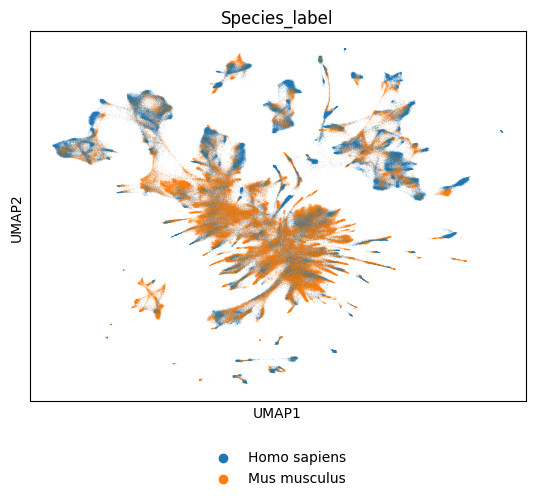

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


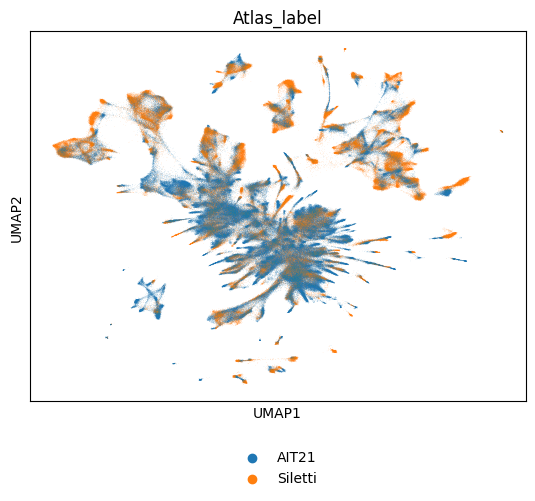

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


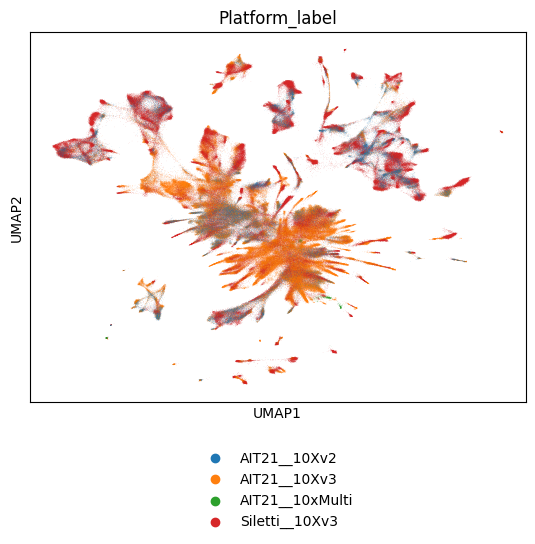

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


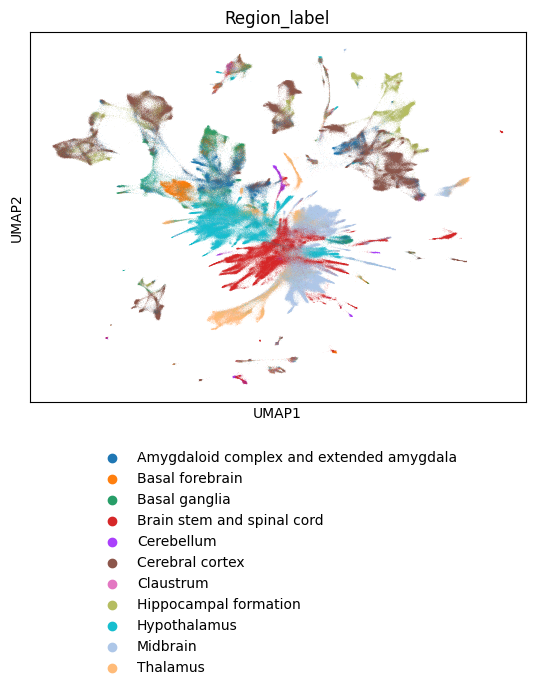

[Plotting UMAPs] runtime: 0 min 28 sec


In [16]:
%matplotlib inline
with time_code('Plotting UMAPs'):
    print(adata, flush=True)
    for umap_label in ['Species_label', 'Atlas_label', 'Platform_label', 'Region_label']:
        fig = sc.pl.umap(
            adata[np.random.permutation(np.arange(adata.shape[0]))],
            color=umap_label,
            return_fig=True,
        )
        legend = fig.axes[0].get_legend()
        if legend is not None:
            legend.set_bbox_to_anchor((0.5, -0.1))  # Adjust legend coordinates
            legend.set_loc('upper center')          # Actually positions legend below
        fig.savefig(
            f'{outdir}/figures/UMAP_{umap_label}.png', bbox_inches='tight'
        )
        plt.show()
        plt.close(fig)